# 06.1o: Radial Neighborhood 3D Visualization (r < 0.01)

**Goal:** Visualize the structure from the black hole core through the cuckoo zone.

We extract all tokens within r < 0.01 from the black hole centroid, encompassing:
- The ultra-dense black hole cluster (r < 1e-4)
- The "cuckoo zone" with wild density variation (1e-4 to 1e-3)
- The beginning of the exclusion zone (1e-3 to 1e-2)

We then:
1. Color-code by radial shell
2. PCA to 3D
3. Generate orthographic projections (XY, XZ, YZ)
4. Create interactive 3D Plotly visualization

This reveals the **geometric structure** that causes the density variations.

This is Volume 6: Pathologies and Singularities

## Parameters

In [55]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# Radial extent to visualize
MAX_RADIUS = 0.01  # 1e-2 gamma units

# Radial shell boundaries for coloring
SHELL_EDGES = [
    (0, 1e-5, 'black', 'Void'),
    (1e-5, 1e-4, 'red', 'Black hole cluster'),
    (1e-4, 1e-3, 'orange', 'Cuckoo zone'),
    (1e-3, 1e-2, 'green', 'Exclusion zone'),
]

# Random seed
RANDOM_SEED = 42

# Visualization
DPI = 300

## Imports

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from sklearn.decomposition import PCA
from collections import defaultdict
import plotly.graph_objects as go

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Identify Black Hole Centroid

In [57]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)
black_hole_set = set(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens")

# Compute centroid
black_hole_embeddings = gamma[black_hole_token_ids]
centroid = black_hole_embeddings.mean(dim=0)
centroid_norm = torch.norm(centroid)

print(f"Black hole centroid norm: {centroid_norm.item():.12f}")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Finding degenerate clusters...

Identified 2100 black hole tokens
Black hole centroid norm: 0.370916873217


## Step 2: Extract Tokens Within r < 0.01

In [58]:
print("\n" + "="*70)
print(f"EXTRACTING TOKENS WITHIN r < {MAX_RADIUS}")
print("="*70)
print()

# Compute distances from centroid
distances = torch.norm(gamma - centroid, dim=1)

# Find tokens within MAX_RADIUS
within_radius = distances <= MAX_RADIUS
neighborhood_token_ids = torch.where(within_radius)[0].tolist()
neighborhood_distances = distances[within_radius]
neighborhood_embeddings = gamma[within_radius]

print(f"Found {len(neighborhood_token_ids):,} tokens within r < {MAX_RADIUS}")
print(f"\nDistance range:")
print(f"  Min: {neighborhood_distances.min().item():.12e}")
print(f"  Max: {neighborhood_distances.max().item():.12e}")


EXTRACTING TOKENS WITHIN r < 0.01

Found 2,221 tokens within r < 0.01

Distance range:
  Min: 1.671334393905e-05
  Max: 9.574378840625e-03


## Step 3: Assign Colors by Radial Shell

In [59]:
print("\n" + "="*70)
print("ASSIGNING COLORS BY RADIAL SHELL")
print("="*70)
print()

distances_np = neighborhood_distances.cpu().numpy()
colors = []
labels = []

for distance in distances_np:
    assigned = False
    for r_inner, r_outer, color, label in SHELL_EDGES:
        if r_inner < distance <= r_outer:
            colors.append(color)
            labels.append(label)
            assigned = True
            break
    if not assigned:
        # Shouldn't happen, but just in case
        colors.append('gray')
        labels.append('Unknown')

# Count tokens per shell
print(f"{'Shell':^20} {'r_inner':>12} {'r_outer':>12} {'Count':>10}")
print("-" * 60)

for r_inner, r_outer, color, label in SHELL_EDGES:
    in_shell = (distances_np > r_inner) & (distances_np <= r_outer)
    count = in_shell.sum()
    print(f"{label:^20} {r_inner:>12.2e} {r_outer:>12.2e} {count:>10,}")


ASSIGNING COLORS BY RADIAL SHELL

       Shell              r_inner      r_outer      Count
------------------------------------------------------------
        Void             0.00e+00     1.00e-05          0
 Black hole cluster      1.00e-05     1.00e-04      2,183
    Cuckoo zone          1.00e-04     1.00e-03         27
   Exclusion zone        1.00e-03     1.00e-02         11


## Step 4: PCA to 3D

In [60]:
print("\n" + "="*70)
print("PCA: PROJECTING TO 3D")
print("="*70)
print()

print(f"Performing PCA on {len(neighborhood_embeddings):,} tokens...\n")

# Perform PCA to 3D
pca = PCA(n_components=3, random_state=RANDOM_SEED)
neighborhood_3d = pca.fit_transform(neighborhood_embeddings.cpu().numpy())

explained_var = pca.explained_variance_ratio_
print(f"PCA explained variance:")
print(f"  PC1: {explained_var[0]*100:.4f}%")
print(f"  PC2: {explained_var[1]*100:.4f}%")
print(f"  PC3: {explained_var[2]*100:.4f}%")
print(f"  Total: {sum(explained_var)*100:.4f}%")


PCA: PROJECTING TO 3D

Performing PCA on 2,221 tokens...

PCA explained variance:
  PC1: 21.0664%
  PC2: 17.4773%
  PC3: 15.9712%
  Total: 54.5148%


## Step 5: Orthographic Projections (2D)


ORTHOGRAPHIC PROJECTIONS



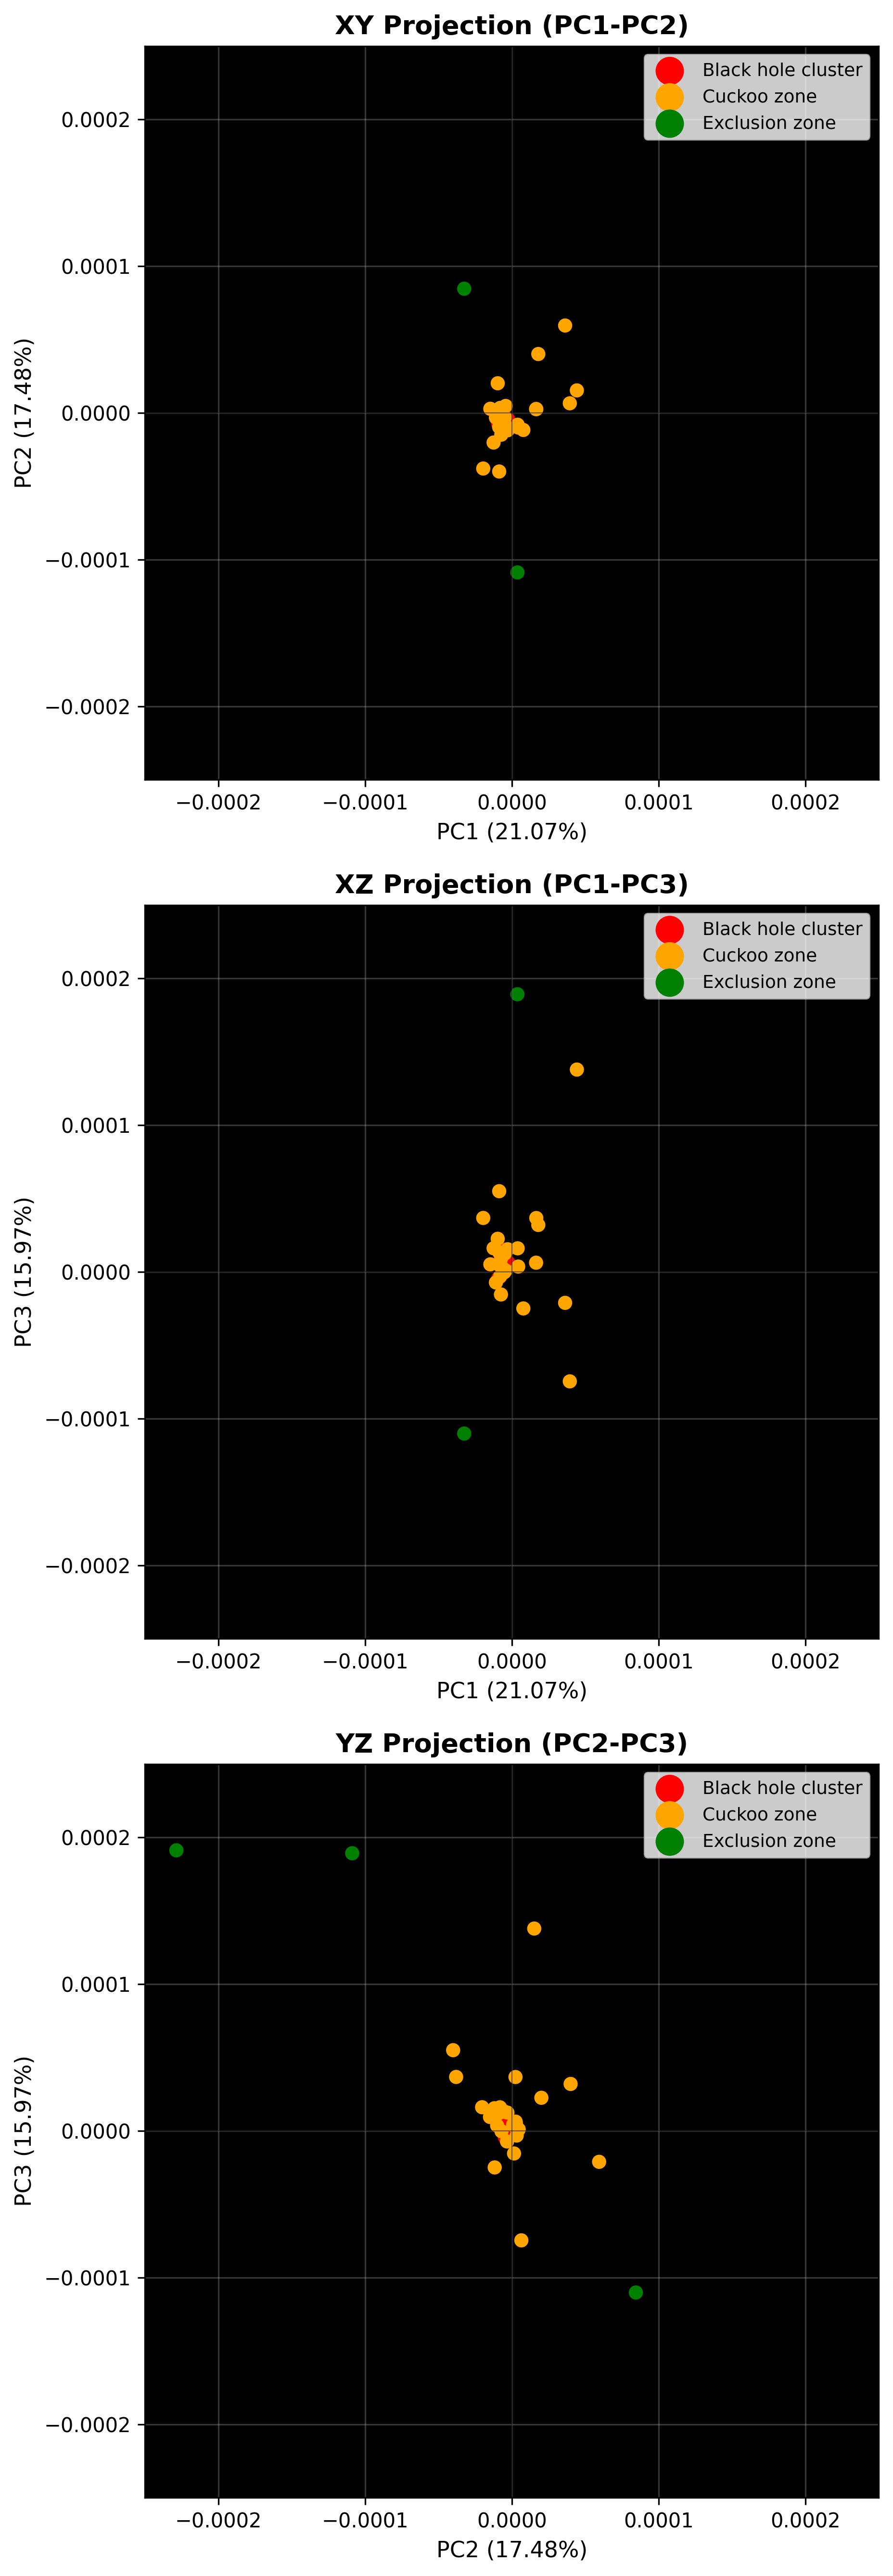

Orthographic projections show 2D views of the 3D structure.
Red = black hole cluster, Orange = cuckoo zone, Yellow = exclusion zone


In [61]:
print("\n" + "="*70)
print("ORTHOGRAPHIC PROJECTIONS")
print("="*70)
print()

fig, axes = plt.subplots(3, 1, figsize=(6, 18), dpi=DPI)

# Create a mapping from color names to actual colors for legend
unique_shells = [(r_inner, r_outer, color, label) for r_inner, r_outer, color, label in SHELL_EDGES]

# Projection 1: XY (PC1 vs PC2)
for r_inner, r_outer, color, label in unique_shells:
    in_shell = (distances_np > r_inner) & (distances_np <= r_outer)
    if in_shell.sum() > 0:
        axes[0].scatter(neighborhood_3d[in_shell, 0], neighborhood_3d[in_shell, 1], 
                       c=color, s=50, alpha=1.0, label=label, edgecolors='none')

axes[0].set_xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=11)
axes[0].set_title('XY Projection (PC1-PC2)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9, loc='upper right', markerscale=2)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5, alpha=0.5)
axes[0].axvline(0, color='k', linewidth=0.5, alpha=0.5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_facecolor('black')  # Black plot background
axes[0].set_xlim([-0.00025, 0.00025])
axes[0].set_ylim([-0.00025, 0.00025])

# Projection 2: XZ (PC1 vs PC3)
for r_inner, r_outer, color, label in unique_shells:
    in_shell = (distances_np > r_inner) & (distances_np <= r_outer)
    if in_shell.sum() > 0:
        axes[1].scatter(neighborhood_3d[in_shell, 0], neighborhood_3d[in_shell, 2], 
                       c=color, s=50, alpha=1.0, label=label, edgecolors='none')

axes[1].set_xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=11)
axes[1].set_ylabel(f'PC3 ({explained_var[2]*100:.2f}%)', fontsize=11)
axes[1].set_title('XZ Projection (PC1-PC3)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper right', markerscale=2)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linewidth=0.5, alpha=0.5)
axes[1].axvline(0, color='k', linewidth=0.5, alpha=0.5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_facecolor('black')  # Black plot background
axes[1].set_xlim([-0.00025, 0.00025])
axes[1].set_ylim([-0.00025, 0.00025])

# Projection 3: YZ (PC2 vs PC3)
for r_inner, r_outer, color, label in unique_shells:
    in_shell = (distances_np > r_inner) & (distances_np <= r_outer)
    if in_shell.sum() > 0:
        axes[2].scatter(neighborhood_3d[in_shell, 1], neighborhood_3d[in_shell, 2], 
                       c=color, s=50, alpha=1.0, label=label, edgecolors='none')

axes[2].set_xlabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=11)
axes[2].set_ylabel(f'PC3 ({explained_var[2]*100:.2f}%)', fontsize=11)
axes[2].set_title('YZ Projection (PC2-PC3)', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9, loc='upper right', markerscale=2)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='k', linewidth=0.5, alpha=0.5)
axes[2].axvline(0, color='k', linewidth=0.5, alpha=0.5)
axes[2].set_aspect('equal', adjustable='box')
axes[2].set_facecolor('black')  # Black plot background
axes[2].set_xlim([-0.00025, 0.00025])
axes[2].set_ylim([-0.00025, 0.00025])

plt.tight_layout()
plt.show()

print("Orthographic projections show 2D views of the 3D structure.")
print("Red = black hole cluster, Orange = cuckoo zone, Yellow = exclusion zone")

## Step 6: Interactive 3D Visualization (Plotly)

In [62]:
print("\n" + "="*70)
print("INTERACTIVE 3D VISUALIZATION")
print("="*70)
print()

# Create Plotly 3D scatter
traces = []

for r_inner, r_outer, color, label in unique_shells:
    in_shell = (distances_np > r_inner) & (distances_np <= r_outer)
    if in_shell.sum() > 0:
        trace = go.Scatter3d(
            x=neighborhood_3d[in_shell, 0],
            y=neighborhood_3d[in_shell, 1],
            z=neighborhood_3d[in_shell, 2],
            mode='markers',
            marker=dict(
                size=3,
                color=color,
                opacity=0.7
            ),
            name=label,
            text=[f'r={d:.6e}' for d in distances_np[in_shell]],
            hovertemplate='%{text}<br>PC1: %{x:.4f}<br>PC2: %{y:.4f}<br>PC3: %{z:.4f}<extra></extra>'
        )
        traces.append(trace)

layout = go.Layout(
    title=f'3D Visualization: Tokens within r < {MAX_RADIUS}',
    scene=dict(
        xaxis_title=f'PC1 ({explained_var[0]*100:.2f}%)',
        yaxis_title=f'PC2 ({explained_var[1]*100:.2f}%)',
        zaxis_title=f'PC3 ({explained_var[2]*100:.2f}%)',
        aspectmode='cube'
    ),
    showlegend=True,
    width=900,
    height=700
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

print("\nInteractive 3D scatter plot created.")
print("Use mouse to rotate, zoom, and explore the structure.")
print("Hover over points to see their radial distance.")


INTERACTIVE 3D VISUALIZATION




Interactive 3D scatter plot created.
Use mouse to rotate, zoom, and explore the structure.
Hover over points to see their radial distance.


## Step 7: Radial Distance Distribution


RADIAL DISTANCE DISTRIBUTION



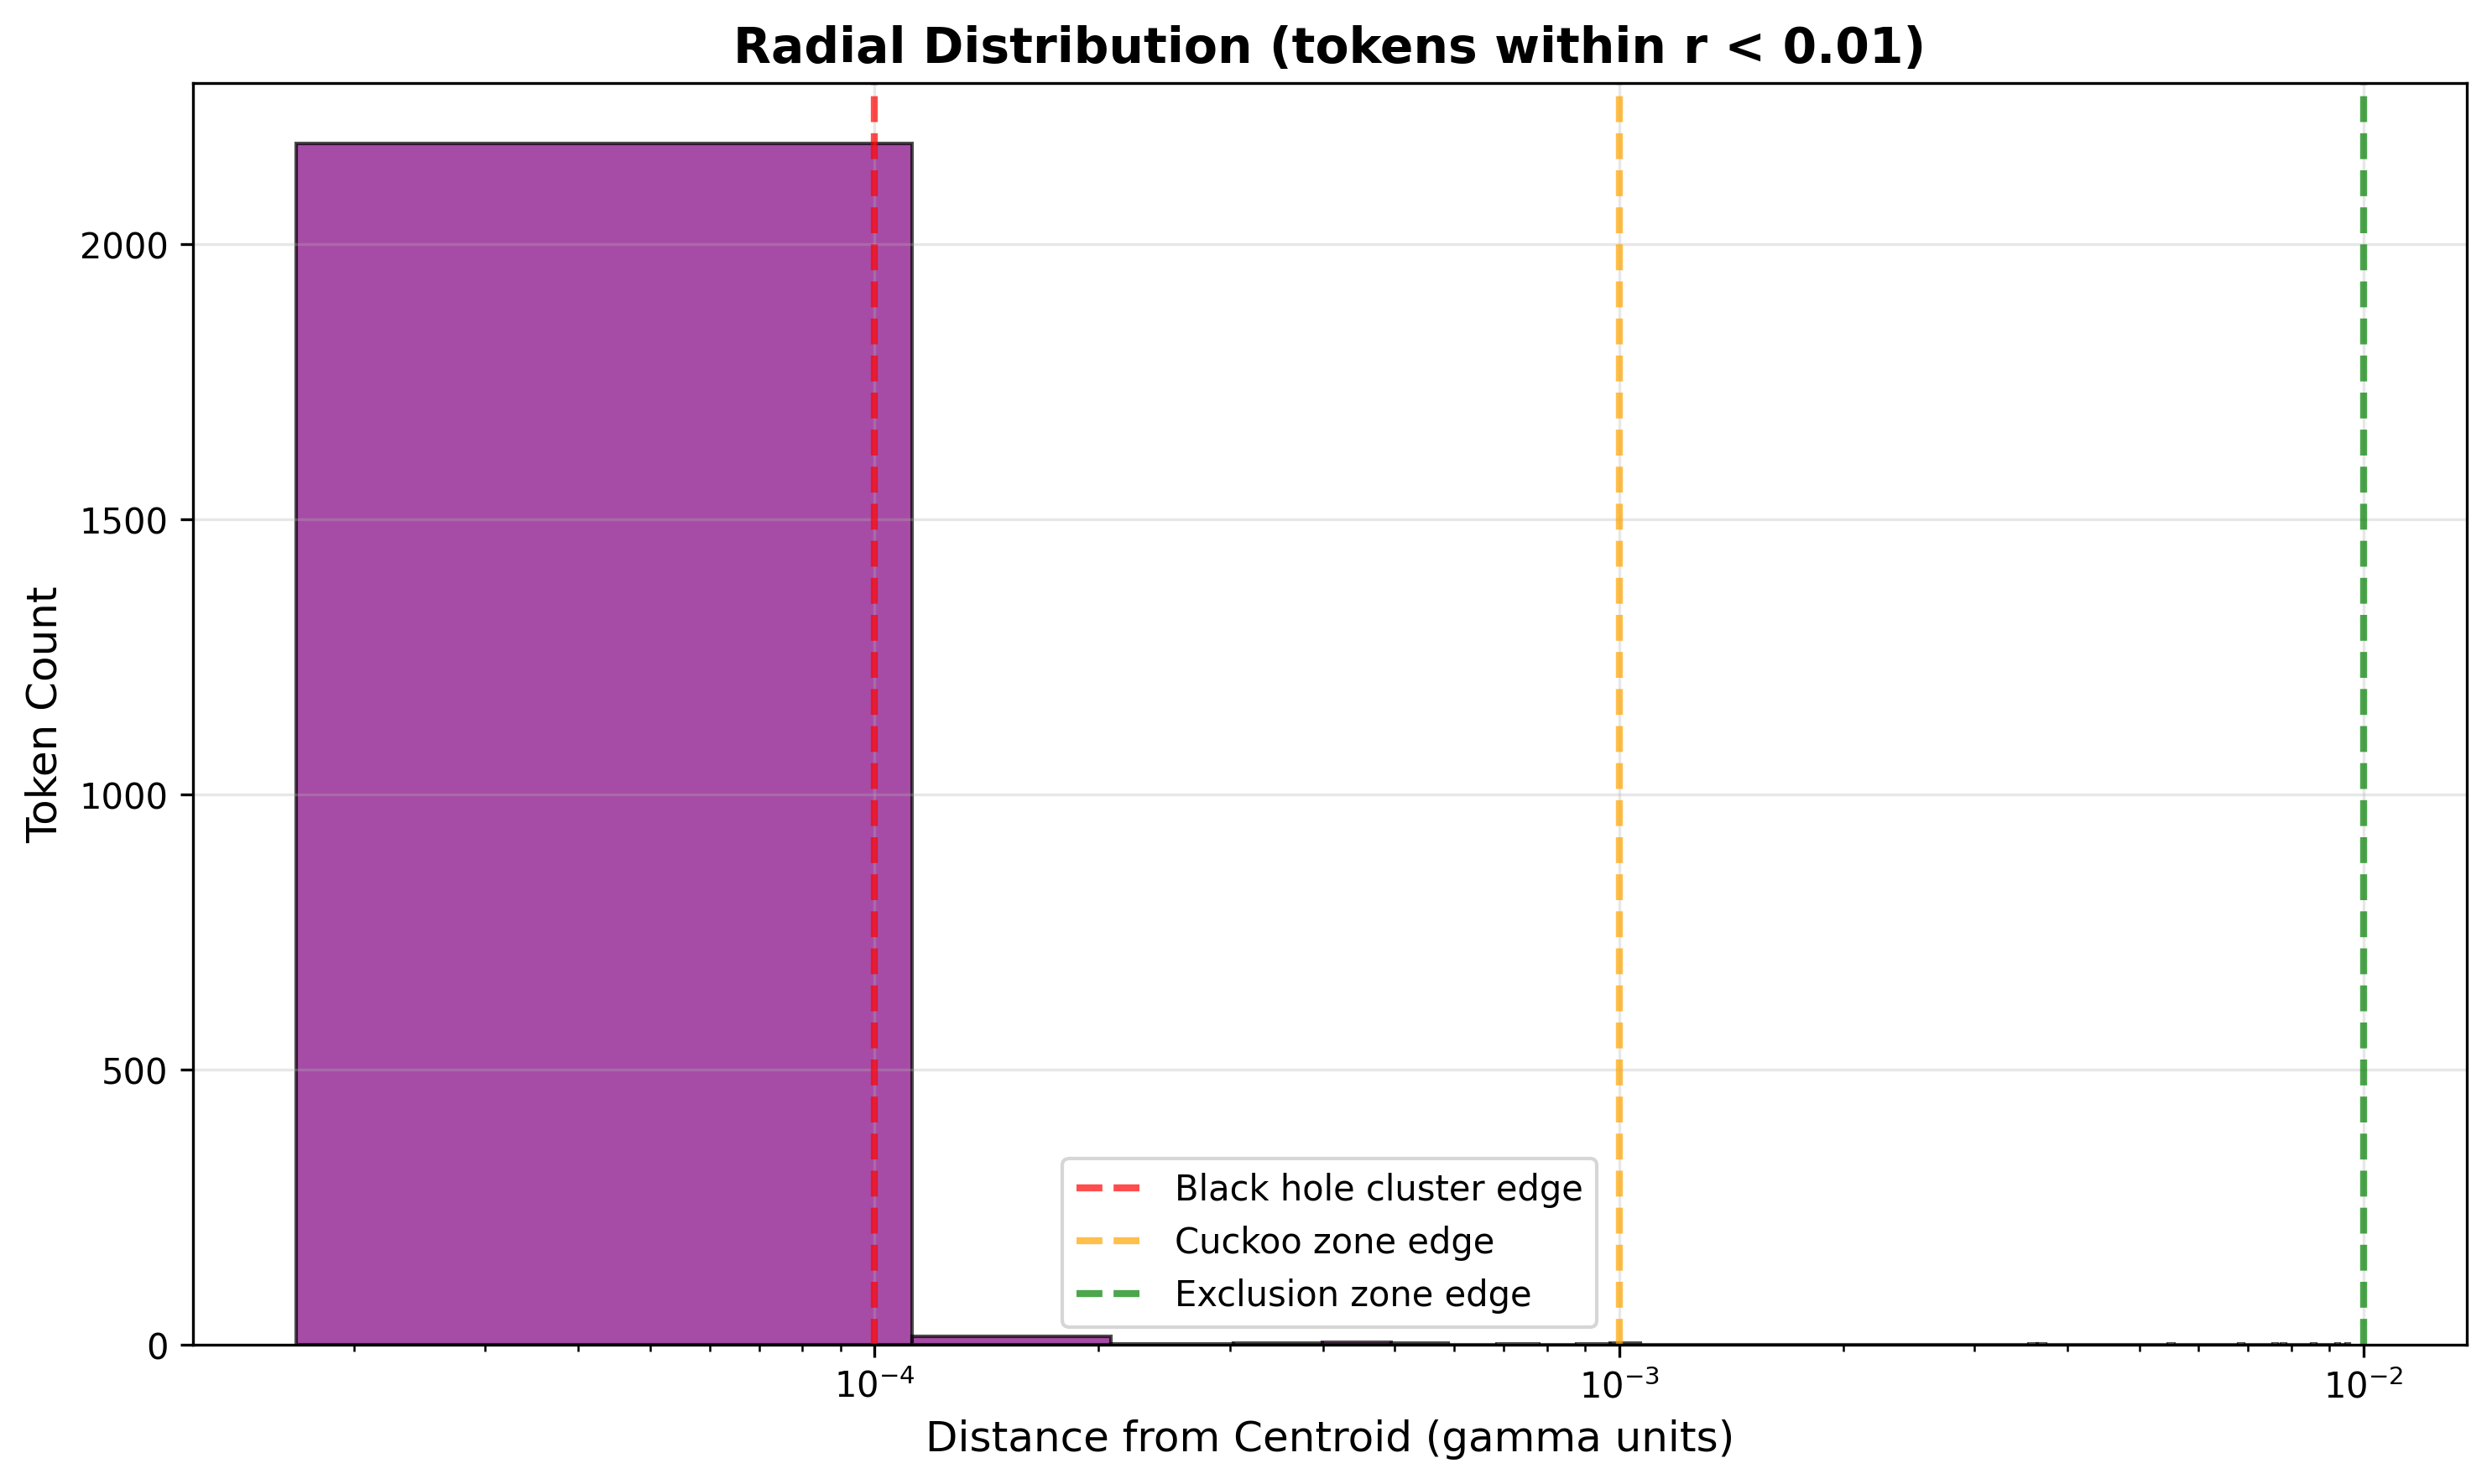


Showing distribution of 2,221 tokens


In [63]:
print("\n" + "="*70)
print("RADIAL DISTANCE DISTRIBUTION")
print("="*70)
print()

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(distances_np, bins=100, color='purple', alpha=0.7, edgecolor='black')

# Mark shell boundaries
for r_inner, r_outer, color, label in SHELL_EDGES[1:]:  # Skip void
    ax.axvline(r_outer, color=color, linestyle='--', linewidth=2, alpha=0.7, label=f'{label} edge')

ax.set_xlabel('Distance from Centroid (gamma units)', fontsize=12)
ax.set_ylabel('Token Count', fontsize=12)
ax.set_xscale('log')
ax.set_title(f'Radial Distribution (tokens within r < {MAX_RADIUS})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nShowing distribution of {len(distances_np):,} tokens")

## Summary

We've visualized the structure from the black hole core through the cuckoo zone.

**Key observations:**
1. **Black hole cluster (red):** Dense ball at r < 1e-4
2. **Cuckoo zone (orange):** Scattered points from 1e-4 to 1e-3 - these are the ~38 tokens with wildly varying local neighborhoods
3. **Exclusion zone begins (yellow):** Sparse scatter from 1e-3 to 1e-2

**Geometric structure:**
- If points are spherically distributed: No preferred direction
- If points form filaments or clusters: Anisotropic structure
- The orthographic projections reveal the shape in 2D slices
- The interactive 3D plot lets you explore from any angle

The "cuckoo zone" variability comes from geometry: some orange points are "on the edge" of the red cluster (high local density looking backward), while others are isolated in the void (low local density looking forward).